# Monte Carlo Methods II: Ising Model and Hopfield Network

## Introduction

In 2024, the **Nobel Prize in Physics** was awarded to **John J. Hopfield** and **Geoffrey E. Hinton** for their pioneering work on neural networks.
Their contributions have played a significant role in the development of modern artificial intelligence and computational models inspired by biological learning mechanisms.

- **John J. Hopfield** introduced the Hopfield network, a type of recurrent neural network that models associative memory and collective computation in neural systems.
- **Geoffrey E. Hinton** made significant advancements in deep learning, particularly in training deep neural networks through the backpropagation algorithm.

Their research has had profound implications in artificial intelligence, neuroscience, and computational physics.

### Why Do Neural Networks Matter?

Neural networks are now an essential part of many everyday technologies:

- **Facial Recognition:** Used to unlock smartphones and enhance security.
- **Chatbots:** Power customer service agents that interact with users.
- **Voice Assistants:** Siri, Alexa, and Google Assistant rely on neural networks for speech recognition.
- **Self-Driving Cars:** Autonomous vehicles process sensor data using deep learning models.

### Importance of This Discovery

Neural networks have revolutionized multiple domains, including:
- **Language Translation:** Real-time translation services are powered by deep learning models.
- **Medical Diagnosis:** AI-assisted analysis of medical images improves diagnostic accuracy.
- **Scientific Research:** AI-driven simulations enhance modeling in physics, chemistry, and biology.

## The Ising Model

To understand how Hopfield networks operate, we first introduce the **Ising model**.

The **Ising model** is a mathematical model in statistical mechanics, introduced by Wilhelm Lenz in 1920 and solved for the one-dimensional case by his student Ernst Ising in 1925.
The model was originally used to explain ferromagnetism, where magnetic materials exhibit spontaneous magnetization due to interactions between neighboring atomic spins.

- Wilhelm Lenz conceived the model as a simplified representation of magnetic interactions in a lattice, where spins can either point "up" (+1) or "down" (-1).
- Ernst Ising solved the one-dimensional version of the model in his doctoral thesis, showing that it did not exhibit phase transitions—a result that was surprising at the time.
- Lars Onsager solved the two-dimensional version of the model in 1944, demonstrating that it undergoes a phase transition at a critical temperature, where spontaneous magnetization occurs.

Since then, the Ising model has become one of the most widely studied models in statistical physics and beyond.
Its applications extend not only to physics (such as in magnetism and lattice gases) but also to fields like biology (neural networks), computer science (optimization problems), and even sociology (modeling opinion dynamics).

The **Metropolis algorithm** (1953) was developed for Monte Carlo simulations of systems like the Ising model, enabling the study of large, complex systems by simulating their thermal fluctuations and statistical properties.
This method revolutionized computational physics and remains a powerful tool in many areas of research today.

#### Basic Idea

- Consider a **grid (lattice)** where each point represents a **spin**.
- Each spin can take one of two states: **up (+1) or down (-1)**.
- Spins interact with their neighbors, aiming to align in a way that minimizes system energy.
- The system's **energy parameter** determines the likelihood of spins flipping, making temperature a crucial factor in system behavior.

Let's start programming as we introduce the different concepts.
Here, we create a python class to keep track of the state and temperature of an Ising Model.

In [1]:
# Subclass a numpy array to store the state of an Ising Model

import numpy as np
from numpy.random import randint

class Ising(np.ndarray):

    def __new__(cls, shape=(64,64), kT=1, seed=None):
        if seed is not None:
            np.random.seed(seed)

        obj = np.random.choice([-1,1], size=shape).view(cls)
        obj.kT = kT
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.kT = getattr(obj, 'kT', None)

With the class `Ising`, we can now instanize a Ising model by creating a 2D grid of spin state:

In [2]:
# HANDSON: instanize a Ising model by creating a 2D grid of spin state.
ising = Ising(kT=1)
ising


Ising([[ 1, -1, -1, ..., -1,  1,  1],
       [ 1,  1, -1, ..., -1,  1, -1],
       [ 1, -1, -1, ..., -1,  1,  1],
       ...,
       [ 1, -1, -1, ..., -1, -1, -1],
       [ 1,  1, -1, ...,  1,  1,  1],
       [ 1, -1, -1, ..., -1, -1, -1]], shape=(64, 64))

We can visualize the spin state by plotting `ising` as an image with `plt.imshow()`:

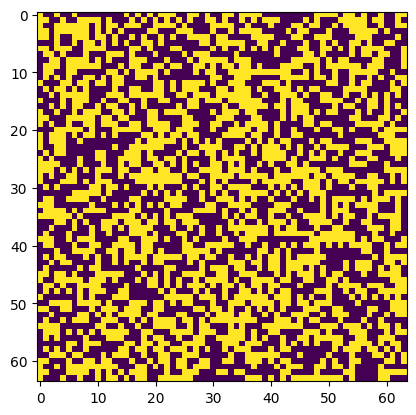

In [3]:
# HANDSON: visualize the spin state by plotting the state as an image
from matplotlib import pyplot as plt
plt.imshow(ising)


### Interaction and Energy Minimization

- The system's total energy is determined by how well-aligned the spins are with their neighbors.
- At **high temperatures**, spins flip frequently due to thermal fluctuations, leading to disorder.
- At **low temperatures**, spins align into ordered configurations, exhibiting phase transitions similar to those in magnetic materials.
- The **Hamiltonian** (energy function) for the Ising model is:
  \begin{align}
  H = - \sum_{i,j} J_{ij} s_i s_j
  \end{align}
  where:
  - $s_i$ represents the spin at site $i$.
  - $J_{ij}$ is the coupling strength between neighboring spins.
- The system evolves dynamically to minimize $H$, leading to patterns of stable configurations.

#### Energy Change Due to Spin Flip

When a single spin $s_i$ flips, the change in energy is calculated by comparing the energy before and after the flip.
The energy difference $\Delta E$ due to flipping the spin at site $i$ is:
\begin{align}
\Delta E = 2 s_i \sum_{j} J_{ij} s_j,
\end{align}
where the sum is over the nearest neighbors $j$ of site $i$.
The factor of 2 arises because flipping the spin at site $i$ changes its contribution to the energy from $-s_i s_j$ to $+s_i s_j$.

Choose $J_{ij}$ so that only neighborhood cells have interaction 1, we can implement the following function:

In [4]:
# HANDSON: please implement the following function according to the above equation

def energy_change(ising, i, j):
    I, J = ising.shape  # Get lattice dimensions
    spin = ising[i, j]  # Current spin value
    
    # Neighboring spins (periodic boundary conditions)
    neighbors = (  ising[(i+1)%I, j] #modulus to make it perioidc at boundary.
                 + ising[(i-1)%I, j]
                 + ising[i, (j+1)%J]
                 + ising[i, (j-1)%J])

    # Energy difference due to spin flip
    return 2 * spin * neighbors

We may now obtain the energy change for flipping a spin at different cells:

In [5]:
# HANDSON: choose different i and j and compute the energy change by calling `energy_change(state, i, j)`
energy_change(ising,3,2)



np.int64(0)

### Metropolis Algorithm

To simulate the evolution of the system at a given temperature, we use the Metropolis algorithm.
This algorithm probabilistically accepts or rejects a spin flip based on the energy change $\Delta E$ and the temperature $T$.
The probability of accepting a spin flip is given by the Boltzmann factor:
\begin{align}
P(\text{flip}) =
\begin{cases}
1 & \text{if } \Delta E < 0, \\
\exp\left(-\frac{\Delta E}{k T}\right) & \text{if } \Delta E \geq 0,
\end{cases}
\end{align}
where:
- $\Delta E$ is the energy change caused by the flip.
- $k$ is the Boltzmann constant.
 $T$ is the temperature.

This allows the system to "explore" higher energy states at higher temperatures (thermal fluctuations), while favoring low-energy configurations as the system cools down.

We can implement a function `flip(ising, i, j)` to determent if we need to flip the spin `ising` at grid `i`, `j`:

In [6]:
# HANDSON: please implement the following function according to the above equation

def flip(ising, i, j):
    dE = energy_change(ising,i,j)

    if dE < 0: return True
    else:
        return np.random.rand() < np.exp(-dE/ising.kT)

Note the `np.random.rand()` function in `flip()`.
Choose a cell with positive energy change and run flip multiple times.
What do you see?

In [7]:
# HANDSON: try repeat flip() many times

ising1 = Ising(kT=10)
np.array([flip(ising1,1,1) for _ in range(100)])


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

What happen if you change the temperature?

In [8]:
# HANDSON: try change `kT` and then repeat flip()
ising2 = Ising(kT=.1)
np.array([flip(ising2,2,4) for _ in range(100)])


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

With the above helper functions, we are ready to implement the Ising Model using the metropolis algorithm:

In [9]:
# HANDSON: please implement the following function according to the metropolis algorithm

def run(ising, N):
    I, J = np.shape(ising)
    for n in range(N):
        i = randint(0,I)
        j = randint(0,J)
        if flip(ising,i,j):
            ising[i,j] *= -1

That's it!
We can how compare the spin state before and after running the simulation.

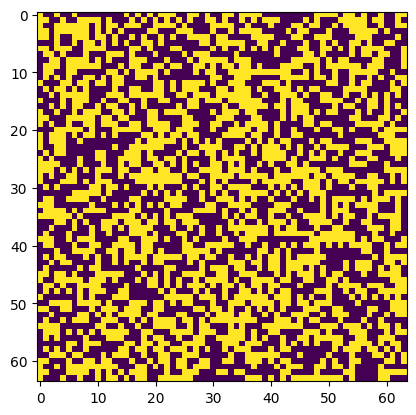

In [10]:
# HANDSON: visualize the initial spin state
plt.imshow(ising)


In [11]:
# HANDSON: run the simuluation for, e.g., 100,000 steps
run(ising,100000)


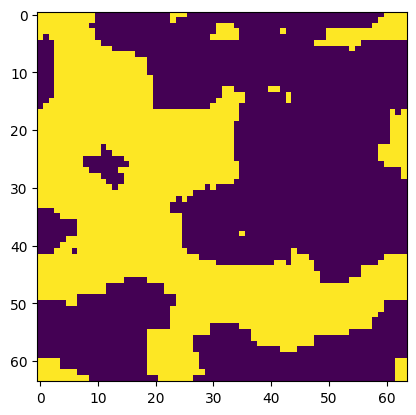

In [12]:
# HANDSON: ... and then visualize the final spin state
plt.imshow(ising)


### Animate the Ising Model

Just for fun, let's definte the following helper function to create animation:

In [13]:
# Define `animate(state, Nsub=100, N=250)` to create animation

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate(state, update, nsub=100, n=250, cmap='viridis'):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    im = ax.imshow(state, cmap=cmap)
    def func(i):
        update(state, nsub)
        im.set_array(state)
        return [im]
    an = FuncAnimation(fig, func, frames=n, interval=40, blit=True)
    plt.close()
    return an

In [14]:
# HANDSON: use the animate(state, update, nsub, n) to create an animation object `an`
ising = Ising(kT =1)
an = animate(ising,run)


In [15]:
# HANDSON: show the animation object as a video using HTML()
HTML(an.to_html5_video())


RuntimeError: Requested MovieWriter (ffmpeg) not available

### Measuring Magnetization

Physically, magnetization measures the net magnetic moment of the system.
In the 2D Ising model, each spin contributes either +1 or -1.
The total magnetization is simply the sum of all spins $M = \sum_i s_i$.

We often normalize the magnetization by dividing by the total number of spins to get a value between -1 and 1:
\begin{align}
m = \frac{1}{N} \sum_i s_i
\end{align}
* If all spins are aligned up, $m = 1$.
* If all spins are aligned down, $m = -1$.
* If spins are randomized, $m \approx 0$.

This normalized magnetization tells us how "ordered" the system is.

In [17]:
# HANDSON: please implement the following function according to the above equation

def mag(ising):
    return np.sum(ising) / ising.size

With this, we can plot the magnetization as function of, e.g., every 1000 steps.

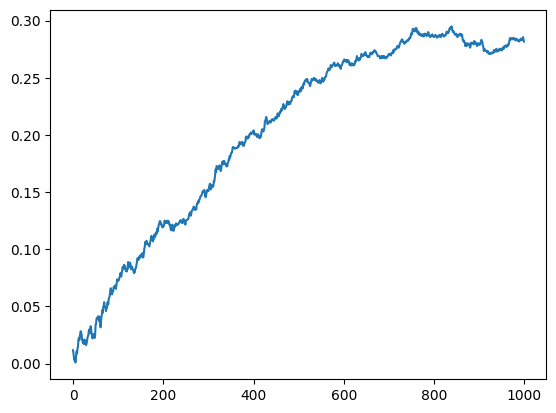

In [18]:
# HANDSON: plot magnetization, i.e., as a function of every 1000 steps for 1000_000 steps in total
ising = Ising()
ms = []
for _ in range(1000):
    run(ising,100)
    ms.append(mag(ising))
plt.plot(ms)


### Phase Transition

The Ising model is important because it is the simplest model that shows phase transition.
The temperature `kT` is the parameter that control the phase.
* At high temperature, thermal fluctuations dominate: the system becomes disordered and $m \approx 0$.
* At low temperature, the system settles into an ordered state: $m \approx \pm1$.
* Near a critical temperature T_c, the system undergoes a phase transition from disordered to ordered.

In [19]:
# HANDSON: Let's implementat a function that takes the temperature
# of an Ising model and returns a list of magnetization

def getmag(kT):
    ising = Ising(kT=kT)
    ms = []
    for _ in range(1000):
        run(ising,100)
        ms.append(mag(ising))

    return ms



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


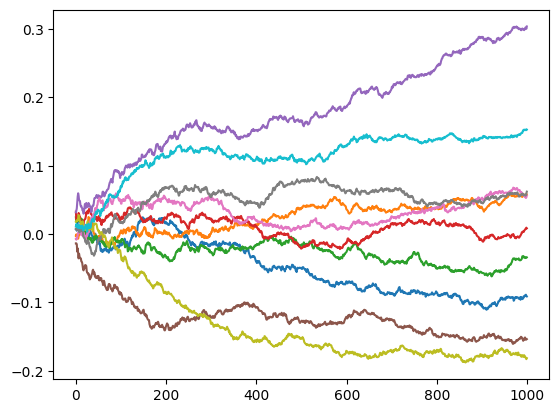

In [22]:
# HANDSON: We can now use getmag(kT) to run numerical experiments.
# First, let's run getmag() and plot the history 10 times for the same temperature.
# You may use the `tqdm` package to obtain a process bar.
!pip install tqdm
from tqdm import tqdm

for _ in tqdm(range(10)):
    ms = getmag(kT=1)
    plt.plot(ms)

In [23]:
# HANDSON: Next, let's run getmag() and plot the history 10 times for different temperature

kTs = np.logspace(-1,1,11)


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


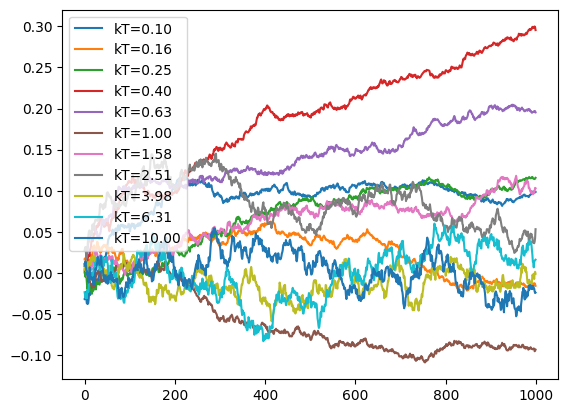

In [25]:
for kT in tqdm(kTs):
    ms = getmag(kT)
    plt.plot(ms,label=f'kT={kT:.2f}')
plt.legend()

You should observe see the magnetization evolves very differently above critical temperature $k T_c \approx 2.27$, which indicates a phase transition.
To make it easier to see, one may plot just the absolute value of the last point of the histories:

In [26]:
# HANDSON: Let's only plot the absolute value of the last point of the histories
msf = [abs(getmag(kT)[-1]) for kT in tqdm(kTs)]


100%|██████████| 11/11 [00:08<00:00,  1.22it/s]


The above plot is a bit noise...  Let's average 10 realizations per temperature:

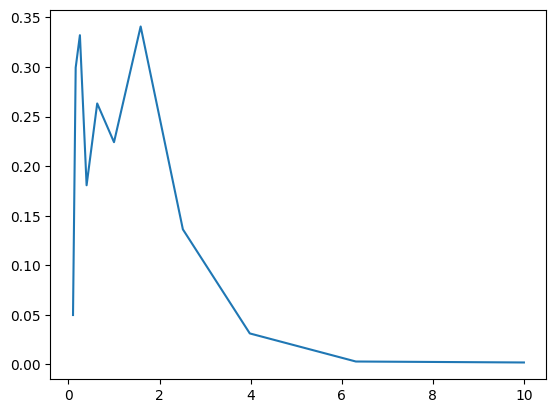

In [29]:
plt.plot(kTs,msf)

In [31]:
# HANDSON: Let's average 10 realizations
ms = [
    np.mean([abs(getmag(kT)[-1]) for _ in range(10)])
    for kT in tqdm(kTs)
]


100%|██████████| 11/11 [01:28<00:00,  8.05s/it]


Phase transition is one of the most striking features of the 2D Ising model!

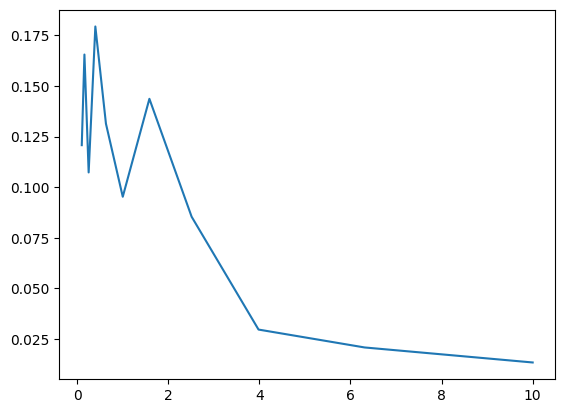

In [33]:
plt.plot(kTs,ms)

### 

## Hopfield Networks

The **Hopfield network**, introduced by **John Hopfield in 1982**, is a recurrent neural network that stores and recalls patterns through energy minimization.

- **Pattern Storage and Recall:** The network can store multiple patterns as stable configurations.
- **Robustness to Noise:** If an input is noisy or incomplete, the network still retrieves the correct stored pattern.
- **Content-Addressable Memory:** Unlike conventional memory, which retrieves data using addresses, Hopfield networks retrieve patterns based on similarity.

### Energy Landscape

The Hopfield network shares deep similarities with the Ising model:
- **Neurons replace spins**, taking binary values $+1$ or $-1$.
- **Connections between neurons** correspond to interactions between spins.
- **The system evolves toward stable, low-energy states**, just like in the Ising model.
- **Both exhibit emergent global order** despite being governed by local interactions.

The energy function of the Hopfield network is given by:
\begin{align}
E = - \sum_{i,j} W_{ij} \sigma_i \sigma_j,
\end{align}
where $W_{ij}$ represents synaptic weights and $\sigma_i$ is the neuron state.

When a neuron updates, its **energy change** follows:
\begin{align}
\Delta E = 2 \sigma_i \sum_j W_{ij} \sigma_j.
\end{align}

### Why It Matters

The Hopfield network played a **foundational role in artificial intelligence** by introducing energy-based models:
- Inspired later developments such as **Boltzmann machines** and **Deep Learning architectures**.
- Showed how memory and pattern recognition could emerge from simple neuron interactions.
- Provided insights into **biological neural networks**, helping us understand how the brain processes and retrieves information.

Because of the similar between a Hopfield network and Ising model, similar, we subclass a numpy array to store the state of a Hopfield network.
Instead of keeping track of the model's temperature `kT`, we create an empty array `W` to store the synaptic weights.m

In [35]:
# Subclass a numpy array to store the state of a Hopfield network

class Hopfield(np.ndarray):

    def __new__(cls, shape=(64,64), seed=None):
        N = shape[0] * shape[1]
        if seed is not None:
            np.random.seed(seed)

        obj   = np.random.choice([-1,1], size=shape).view(cls)
        obj.W = np.zeros((N, N))
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.W = getattr(obj, 'W', None)

By default, an instance of the Hopfield class is random.

In [38]:
# HANDSON: instanize a Hopfield network and visualize its initial random state

hopfield = Hopfield()
hopfield.W

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4096, 4096))

### Hebbian Learning Rule

The weights in a Hopfield network are learned using the Hebbian learning rule, which strengthens the connections between neurons that are activated together.
It is given by:
$$
W_{ij} = \frac{1}{P} \sum_p \sigma_i^{(p)} \sigma_j^{(p)}.
$$
Where:
* $N$ is the number of neurons.
* $P$ is the number of patterns.
* $\sigma_i^{(p)}$ is the state of neuron $i$ in a pattern $p$.

This makes Hopfield networks **powerful for associative memory**, allowing pattern retrieval even with noise.

Using `numpy`'s function, it is straightforward to implement Hebbian's learning rule:

In [39]:
# HANDSON: please implement the following function according to the above equation

def learn(hopfield, patterns):
    for pattern in patterns:
        assert pattern.shape == hopfield.shape
        p = pattern.flatten()
        hopfield.W += np.outer(p,p)

    np.fill_diagonal(hopfield.W,0)
    hopfield.W/len(patterns)

To test it out, let's download some sample images and read them into this notebook.
Because downloading images does not affect our understanding of Hopfield network, let's just run the following code cells directly:

In [40]:
# Download images from GitHub in case this notebook is opened in Google colab

url  = "https://raw.githubusercontent.com/rndsrc/2024_nobel-phys_hs/refs/heads/main/images/"
url1 = url + "AI.jpg"
url2 = url + "cloud.jpg"
url3 = url + "computer.jpg"

! if [ ! -d images ]; then mkdir images && cd images && wget {url1} && wget {url2} && wget {url3}; fi

--2025-04-03 20:29:19--  https://raw.githubusercontent.com/rndsrc/2024_nobel-phys_hs/refs/heads/main/images/AI.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14238 (14K) [image/jpeg]
Saving to: ‘AI.jpg’

AI.jpg              100%[===================>]  13.90K  --.-KB/s    in 0.001s  

2025-04-03 20:29:19 (16.4 MB/s) - ‘AI.jpg’ saved [14238/14238]

--2025-04-03 20:29:19--  https://raw.githubusercontent.com/rndsrc/2024_nobel-phys_hs/refs/heads/main/images/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
200 OKequest sent, awaiting response... 
Length: 14206 (14K) [image/jpe

In [41]:
# Define a helper function to read images

from matplotlib import image as img

def load(filename):
    im = img.imread(filename)
    if im.ndim == 3:
        im = np.mean(im, axis=-1)   # Convert to grayscale if needed
    im = np.where(im < 128, -1, 1)  # Convert grayscale to binary (-1, 1)
    return im

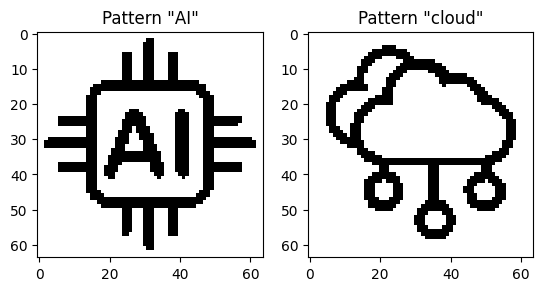

In [42]:
# Load images and display them

im1 = load("images/AI.jpg")
im2 = load("images/cloud.jpg")

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(im1, cmap='gray')
ax0.set_title('Pattern "AI"')
ax1.imshow(im2, cmap='gray')
ax1.set_title('Pattern "cloud"')
plt.show()

With these sample images, let's make our Hopfield network learn from these patterns.
Note that the state of the Hopfield network has not change.
It is still random.

In [43]:
# HANDSON: check what happen to the Hopfield state after learning the patterns

learn(hopfield,[im1,im2])


Once the patterns are learn, we can recall each pixel value by:
\begin{align}
  \sigma_i^{(p)} = \text{sgn}\left(\sum_j W_{ij} \sigma_j^{(p)}\right)
\end{align}
which can be implemented as:

In [44]:
# HANDSON: please implement the following function according to the above equation

def recall(hopfield, N):
    for _ in range(N):
        i = randint(0,hopfield.shape[0])
        j = randint(0,hopfield.shape[1])
        #standard formula for flattened index
        index = i*hopfield.shape[1] + j
        hopfield[i,j] = np.sign(np.dot(hopfield.W[index],hopfield.flatten()))
        

That's it!
We've implemented all the functions of the Hopfield network!
We can "recall" its memory and visulize the result by:

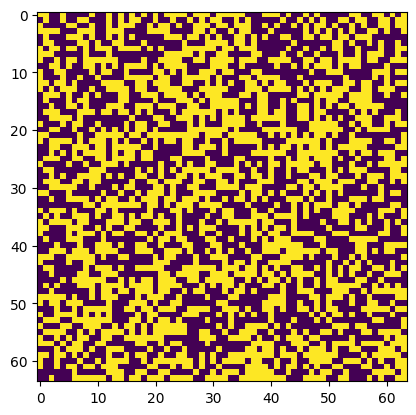

In [45]:
plt.imshow(hopfield)

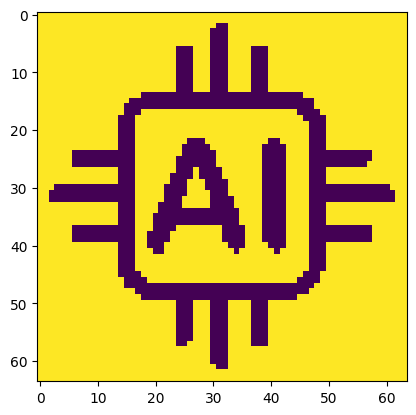

In [47]:
# HANDSON: recall a pattern and visualize the result
recall(hopfield,100_000)
plt.imshow(hopfield)


### Animate the Hopfield Network

Just for fun again, we can now combine the implemented Hopfield network with the `animate(state, update, nsub, n)` helper function that we defined at the very beginning.

The `recall()` function that we implemented actually has the same call signature as the `update()` function.
Hence, we can use it to create the animation:

In [ ]:
# HANDSON: animate memory recall of a Hopfield network



## Discussion

This notebook has demonstrated how concepts from physics and AI intersect through models like the Ising Model and Hopfield Networks. Here are some questions to encourage further exploration:

How do energy minimization principles in physics apply to AI and machine learning?
Can you think of other real-world phenomena that could be modeled using energy-based systems?
How might AI benefit from further insights from statistical mechanics and physics?
What improvements could be made to the Hopfield Network to make it more efficient?
For further study, students can explore more advanced models such as Boltzmann Machines, Restricted Boltzmann Networks, and Deep Learning frameworks.